In [141]:
import pandas as pd
import re,os
import numpy as np
from datetime import datetime,date,timedelta

#wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.draw.dispersion import dispersion_plot
import matplotlib
pd.set_option('display.max_colwidth', None)

df = pd.read_excel(r'C:\Users\STSC\Desktop\Text mining\Project\NLP_conf_call_data (2).xlsx')
#df.columns
df.describe()

,Unnamed: 0,Unnamed: 0.1,prev_day_ret%,release_day_ret%,next_day_ret%,poss_early_release,speech_sentiment_score,speech_subjectivity,speech_complexity,QA_sentiment_score,QA_subjectivity,QA_complexity,url_source
count,490.00000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,0.0
mean,244.50000,245.50000,0.141571,0.289469,0.128510,0.428571,0.173100,0.423999,11.860776,0.167242,0.422577,8.971510,NaN
std,141.59508,141.59508,2.414539,3.626375,4.129608,0.495377,0.095050,0.091815,2.252105,0.058386,0.127231,2.372498,NaN
min,0.00000,1.00000,-19.790000,-16.770000,-19.350000,0.000000,0.000000,0.000000,7.200000,0.000000,0.000000,0.800000,NaN
25%,122.25000,123.25000,-0.740000,-1.255000,-1.757500,0.000000,0.120632,0.390784,10.632500,0.155681,0.423387,8.390000,NaN
50%,244.50000,245.50000,0.260000,0.050000,-0.100000,0.000000,0.159953,0.424258,11.620000,0.173785,0.448674,9.155000,NaN
75%,366.75000,367.75000,1.422500,1.605000,1.480000,1.000000,0.196518,0.458068,12.630000,0.192948,0.471361,9.967500,NaN
max,489.00000,490.00000,11.740000,28.280000,26.040000,1.000000,0.800000,0.900000,26.000000,0.400000,0.800000,18.980000,NaN


In [145]:
#The distribution of review sentiment polarity score
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
x= df['speech_sentiment_score'].iplot(
    kind='hist',
    #bins=[0.00,0.15,0.30,0.45,0.60,0.75,1.00],
    bins=10,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution of Speech Sentiment Score')

<AxesSubplot:xlabel='Return_Driver'>

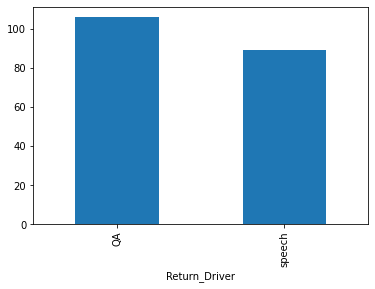

In [163]:
df_subset = df[['qtr_year', 'release_dt',
       'ticker', 'prev_day_ret%', 'release_day_ret%', 'next_day_ret%',
       'poss_early_release','speech_sentiment_score',
       'speech_subjectivity', 'speech_complexity', 'speech_overall_sentiments', 'QA_sentiment_score', 'QA_subjectivity', 'QA_complexity',
       'Return_Driver', 'QA_overall_sentiments']]

df_max_speech = df_subset.loc[(df_subset['speech_sentiment_score'] > 0.173100)]
#print('\nResult dataframe :\n', df_max_speech)
#df_max_speech.count()
df_max_speech.groupby('Return_Driver').size().plot.bar()

Vast majority of the sentiment polarity scores are greater than zero, means most of them are pretty positive.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [153]:
df['QA_sentiment_score'].iplot(
    kind='hist',
    bins=10,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution of QA Sentiment Score')

<AxesSubplot:xlabel='Return_Driver'>

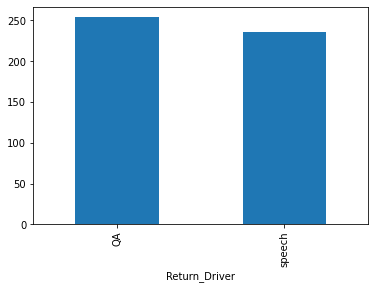

In [162]:
df_subset = df[['qtr_year', 'release_dt',
       'ticker', 'prev_day_ret%', 'release_day_ret%', 'next_day_ret%',
       'poss_early_release','speech_sentiment_score',
       'speech_subjectivity', 'speech_complexity', 'speech_overall_sentiments', 'QA_sentiment_score', 'QA_subjectivity', 'QA_complexity',
       'Return_Driver', 'QA_overall_sentiments']]

df_max_QnA = df_subset.loc[(df_subset['QA_sentiment_score'] > 0.167242)]
#print('\nResult dataframe :\n', df_max_speech)
#df_max_QnA.count()
df.groupby('Return_Driver').size().plot.bar()

In [164]:
import re
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

speech = ''
q_and_a = ''
for i in range(len(df)):
    #if df['ticker'][0] == 'AAPL':
        speech += df["speech"][i]
        q_and_a += df["Q_and_A"][i]

filtered_seq = [w for w in word_tokenize(speech)]
fdist = FreqDist(filtered_seq)
#get top 10 most common words
print("Top 10 frequent words in speech before cleaning :{}".format(fdist.most_common(10)))

Top 10 frequent words in speech before cleaning :[(',', 73521), ('.', 66602), ('the', 61391), ('and', 46636), ('to', 45389), ('of', 39281), ('in', 31219), ('our', 27559), ('we', 25873), ('a', 21843)]


In [93]:
import re
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

speech = ''
q_and_a = ''
for i in range(len(df)):
    if df['ticker'][i] == 'AAPL':  #for a particular ticker
        speech += df["speech"][i]
        q_and_a += df["Q_and_A"][i]

filtered_seq = clean_text(speech)
fdist = FreqDist(filtered_seq)
#get top 10 most common words
print("Top 10 frequent words in Speech after Cleaning / particular company :{}".format(fdist.most_common(10)))

Top 10 frequent words in Speech after Cleaning / particular company :[('apple', 411), ('quarter', 386), ('new', 347), ('year', 344), ('revenue', 298), ('billion', 296), ('services', 218), ('time', 200), ('iphone', 187), ('record', 149)]


In [114]:
import re
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist


def getWordsBasedOnFilter(df,ticker_name, quarter = ""):
    
    speech_list = []
    q_and_a_list = []
    
    if ticker_name != "" and quarter != "":  #filter by ticker_name and quarter
        speech_list = df[(df["ticker"]==ticker_name) & (df["qtr_year"]==quarter)]['speech']
        q_and_a_list = df[(df["ticker"]==ticker_name) & (df["qtr_year"]==quarter)]['Q_and_A']
      
        
    elif ticker_name != "" and quarter == "":   #filter by ticker_name
        speech_list = df[(df["ticker"]==ticker_name)]['speech']
        q_and_a_list = df[(df["ticker"]==ticker_name)]['Q_and_A']
        
    elif ticker_name == "" and quarter != "":    #filter by quarter
        speech_list = df[(df["qtr_year"]==quarter)]['speech']
        q_and_a_list = df[(df["qtr_year"]==quarter)]['Q_and_A']
        
    else:
        print("Please provide one or more value to filter the data")
        
    speech = ''
    q_and_a = ''
    if len(speech_list) != 0:
        speech = "".join([str(x) for x in speech_list])
        
        
    if len(q_and_a_list) != 0:
        q_and_a = "".join([str(x) for x in q_and_a_list])
       
    return speech,q_and_a
        
        
#     for i in range(len(df)):
#         if df['ticker'][i] == val:
#             speech += df["speech"][i]
#             q_and_a += df["Q_and_A"][i]
            
#     return speech,q_and_a

In [76]:
def clean_text(text):
    text = text.lower()   # lower text
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    text = tokenizer.tokenize(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]  # remove words that contain numbers
    stop = nltk.corpus.stopwords.words('english')
    stop=set(stop)
    
    text = [x for x in text if x not in stop]#remove english stop words and words which appear frequently like shirts
    
    text = [t for t in text if len(t) > 2]
    
    return text
    

In [77]:
from wordcloud import WordCloud, ImageColorGenerator

def createWordCloud(words,title,max_words=200):
    wc = WordCloud(background_color = 'white', max_font_size = 50, max_words =max_words,contour_width=3,contour_color='firebrick')
    wc.generate(str(words))
    plt.figure(figsize =[10,10])
    plt.imshow(wc, interpolation="bilinear", aspect="equal")
    plt.axis("off")
    plt.title(title, fontsize = 20)
    plt.show()

    wc.to_file('wordCloud'+title+'.png')


## Word cloud of speech and QA(speech and qa are filtered by ticker and quarter )

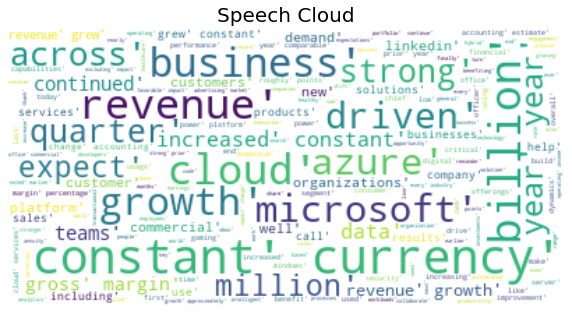

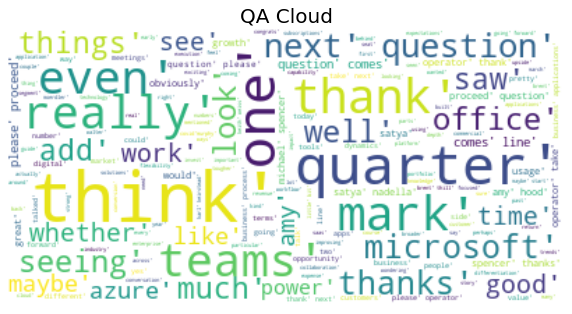

In [78]:
speech_list,qa_list = getWordsBasedOnFilter(df,"MSFT", 'Q2 2021') 
clean_speech_words = clean_text(speech_list)
clean_qa_words = clean_text(qa_list)

#create word cloud for speech and qa
createWordCloud(clean_speech_words,"Speech Cloud")
createWordCloud(clean_qa_words, "QA Cloud")

## Word cloud of speech and QA(speech and qa are filtered by ticker)

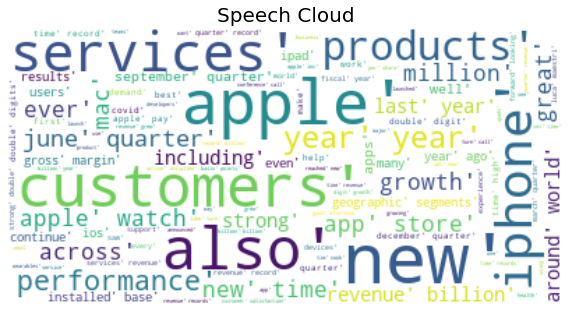

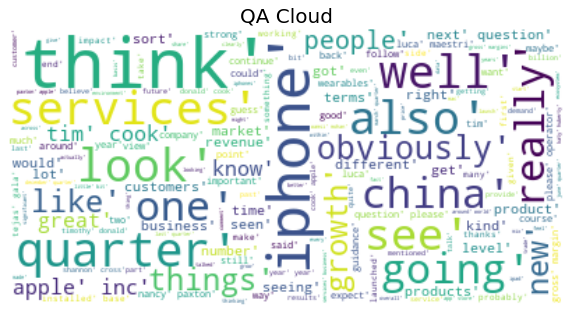

In [94]:
speech_list,qa_list = getWordsBasedOnFilter(df,"AAPL", "") 
clean_speech_words = clean_text(speech_list)
clean_qa_words = clean_text(qa_list)

#create word cloud for speech and qa
createWordCloud(clean_speech_words,"Speech Cloud")
createWordCloud(clean_qa_words, "QA Cloud")

## Word cloud of speech and QA(speech and qa are filtered by quarter)

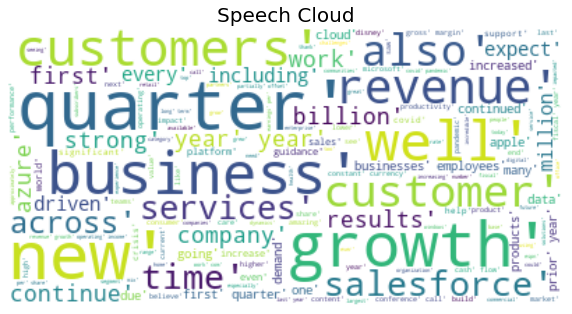

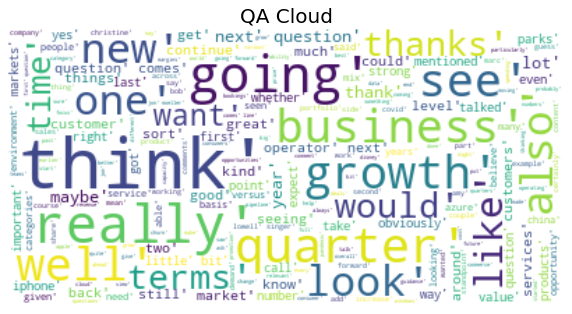

In [95]:
speech_list,qa_list = getWordsBasedOnFilter(df,"","Q1 2021") 
clean_speech_words = clean_text(speech_list)
clean_qa_words = clean_text(qa_list)

#create word cloud for speech and qa
createWordCloud(clean_speech_words,"Speech Cloud")
createWordCloud(clean_qa_words, "QA Cloud")

In [96]:
def get_common_words(word_list,top_num):
    common_words = []
    fdist = FreqDist(word_list)
    common_words = fdist.most_common(top_num)
    print('\n Below are the top {} common words \n {}'.format(top_num,common_words))
    fdist.plot(top_num)

In [108]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

Dropdown(description='Company:', options=('Apple', 'MSFT', 'Tesla'), value='Apple')

Output()

In [165]:
def visualization(tickker):  
    #create word cloud for speech and qa
    speech_list,qa_list = getWordsBasedOnFilter(df,tickker) 
    clean_speech_words = clean_text(speech_list)
    clean_qa_words = clean_text(qa_list)
    createWordCloud(clean_speech_words,"Speech Cloud")
    createWordCloud(clean_qa_words, "QA Cloud")
    
    #displays top 20 common word plot

    most_common_words = get_common_words(clean_speech_words,20) 
    
    
    topics=['products','quarter','new','year','revenue','service','strong']
    dispersion_plot(text,topics) # the dispersion_plot only words for tokenized text

interact(visualization, tickker=df.ticker.unique())


interactive(children=(Dropdown(description='tickker', options=('AAPL', 'MSFT', 'AMT', 'EMHTF', 'AMZN', 'FB', '…

<function __main__.visualization(tickker)>

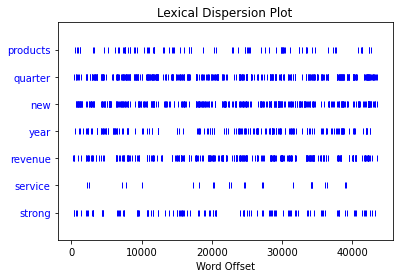

In [99]:
speech_list,qa_list = getWordsBasedOnFilter(df,"AAPL","")
text=nltk.word_tokenize(speech_list)
topics=['products','quarter','new','year','revenue','service','strong']
dispersion_plot(text,topics) # the dispersion_plot only words for tokenized text


 Below are the top 20 common words 
 [('quarter', 688), ('year', 630), ('billion', 343), ('second', 263), ('revenue', 259), ('business', 241), ('growth', 237), ('million', 228), ('customers', 220), ('call', 181), ('also', 180), ('new', 174), ('continue', 174), ('covid', 167), ('strong', 157), ('results', 149), ('first', 145), ('well', 143), ('approximately', 139), ('sales', 138)]


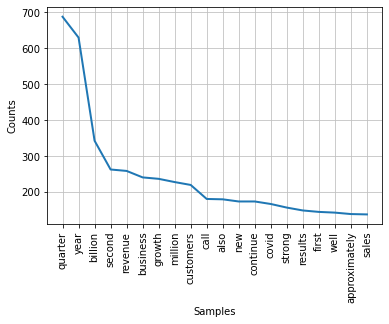

In [100]:
#Get top 20 words for Microsoft
speech_list,qa_list = getWordsBasedOnFilter(df,"","Q2 2020")
clean_speech_words = clean_text(speech_list)
most_common_words = get_common_words(clean_speech_words,20) #displays top 20 common word plot

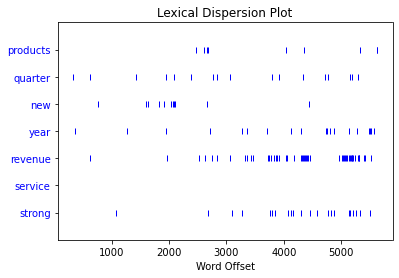

In [101]:
speech_list,qa_list = getWordsBasedOnFilter(df,"MSFT","Q2 2021")
text=nltk.word_tokenize(speech_list)
topics=['products','quarter','new','year','revenue','service','strong']
dispersion_plot(text,topics) # the dispersion_plot only words for tokenized text